# Multi-plane & Multi-source Cluster Lens Simulation, Injection into DP0.2 Cutouts and Modelling

In [2]:
import slsim.Sources as sources
import slsim.Pipelines as pipelines
import slsim.Deflectors as deflectors
from slsim.ImageSimulation.image_simulation import (
    rgb_image_from_image_list,
)
from slsim.LsstSciencePipeline import lsst_science_pipeline
from slsim.Lenses.lens_pop import LensPop
from slsim.Lenses.lens import Lens
from slsim.Plots.lens_plots import LensingPlots
from slsim.Util import param_util

from lenstronomy.Plots import lens_plot
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.util as util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.Util.decouple_multi_plane_util import (
    setup_grids,
    setup_lens_model,
    decoupled_multiplane_class_setup,
    coordinates_and_deflections,
)
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Data.coord_transforms import Coordinates

from time import time
from lsst.afw.image import ExposureF, ImageU, ImageF
from matplotlib.patches import Rectangle
from lsst.geom import SpherePoint, degrees

import numpy as np
import matplotlib.pyplot as plt

from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from copy import deepcopy

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


Load a cluster catalog. This is an example of a few clusters from redMaPPer

In [3]:
cluster_catalog = Table.read("../data/redMaPPer/clusters_example.fits")
members_catalog = Table.read("../data/redMaPPer/members_example.fits")

Cluster has redshift and richness. A NFW halo is used to describe its mass based on a mass-richness relation.

### Rank clusters by their richness.

In [4]:
members_df = members_catalog.to_pandas()
clusters_df = cluster_catalog.to_pandas()

member_counts_df = (
    members_df.groupby("cluster_id").size().reset_index(name="member_count")
)

cluster_with_counts = clusters_df.merge(member_counts_df, on="cluster_id", how="left")
cluster_with_counts["member_count"] = cluster_with_counts["member_count"].fillna(0)

cluster_ranked = cluster_with_counts.sort_values("richness", ascending=False)
cluster_catalog_ranked = Table.from_pandas(cluster_ranked)

print("Detailed cluster ranking:")
print("Rank | Cluster ID | Members | Richness | Redshift")
print("-" * 50)
for i, cluster in enumerate(cluster_catalog_ranked[:20]):
    print(
        f"{i+1:4d} | {cluster['cluster_id']:10d} | {cluster['member_count']:7d} | "
        f"{cluster['richness']:8.2f} | {cluster['z']:8.3f}"
    )

Detailed cluster ranking:
Rank | Cluster ID | Members | Richness | Redshift
--------------------------------------------------
   1 |          7 |      56 |    82.55 |    0.300
   2 |         47 |      50 |    73.08 |    0.557
   3 |        139 |      15 |    72.94 |    0.446
   4 |         53 |      73 |    70.10 |    0.639
   5 |         22 |      29 |    67.95 |    0.334
   6 |         71 |      42 |    65.30 |    0.583
   7 |         31 |      32 |    63.85 |    0.399
   8 |         93 |      42 |    60.75 |    0.714
   9 |         44 |      30 |    60.37 |    0.264
  10 |        290 |       9 |    57.23 |    0.749
  11 |        190 |      48 |    55.91 |    0.733
  12 |        108 |      56 |    53.88 |    0.808
  13 |         68 |      17 |    53.17 |    0.431
  14 |        217 |      43 |    53.09 |    0.439
  15 |        129 |      40 |    51.70 |    0.393
  16 |        263 |      35 |    51.46 |    0.760
  17 |        208 |      64 |    50.25 |    0.669
  18 |         97 |    

## System construction

#### Here we construct the source galaxy population, for the total LSST FOV area of 9.6 deg2 iff multiple deepCoadds are processed, and 0.054 deg2 for only one deepCoadd injection.

In [5]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.04897)

sky_area = Quantity(value=0.0544, unit="deg2")

kwargs_deflector_cut = {"band": "g", "band_max": 22, "z_min": 0.2, "z_max": 1.0}
kwargs_source_cut = {"band": "g", "band_max": 22, "z_min": 0.21, "z_max": 5.0}

galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=sky_area,
    filters=None,
)
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

In [6]:
print(f'sky area: {sky_area} = {sky_area.to("arcsec2")}')
print(f"number of sources: {source_galaxies.source_number_selected}")

sky area: 0.0544 deg2 = 705023.9999999999 arcsec2
number of sources: 164


In [7]:
deepCoadd_area = Quantity(value=(4200 * 0.2) ** 2, unit="arcsec2")
cutout_area = Quantity(value=(500 * 0.2) ** 2, unit="arcsec2")
print(f'deepCoadd area: {deepCoadd_area} = {deepCoadd_area.to("deg2")}')
print(f'cutout area: {cutout_area} = {cutout_area.to("deg2")}')
source_number_in_deepCoadd = int(
    source_galaxies.source_number_selected
    * (deepCoadd_area / sky_area).decompose().value
)
source_number_in_cutout = int(
    source_galaxies.source_number_selected * (cutout_area / sky_area).decompose().value
)
print(f"number of sources in cutout area: {source_number_in_cutout}")
print(f"number of sources in deepCoadd area: {source_number_in_deepCoadd}")

deepCoadd area: 705600.0 arcsec2 = 0.05444444444444445 deg2
cutout area: 10000.0 arcsec2 = 0.0007716049382716049 deg2
number of sources in cutout area: 2
number of sources in deepCoadd area: 164


In [8]:
lens_clusters = deflectors.ClusterDeflectors(
    cluster_list=cluster_catalog_ranked,
    members_list=members_catalog,
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=sky_area,
    kwargs_draw_members={"max_dist": 60},
    assign_galaxy_redshift=True,
)
print(f"number of deflectors: {lens_clusters.deflector_number()}")

lenspop = LensPop(
    deflector_population=lens_clusters,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

number of deflectors: 65


/grad/a.saricaoglu/home_repos/slsim_lsstsw/lsst_stack/slsim/slsim/Deflectors/DeflectorPopulation/cluster_deflectors.py:79: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


#### Choose cluster from the cluster population.
 I chose the one with highest richness (at index 0 in the ranked list) for demonstration.

In [9]:
print(lens_clusters.draw_cluster(index=0))
cluster_id = lens_clusters.draw_cluster(index=0)["cluster_id"]
cluster_redshift = lens_clusters.draw_cluster(index=0)["z"]

{'cluster_id': np.int16(7), 'richness': np.float32(82.55), 'z': np.float32(0.2999), 'member_count': np.int64(56), 'halo_mass': np.float64(747212304809984.0), 'concentration': np.float64(2.739989130670444), 'vel_disp': np.float64(881.6009501761448), 'e1_mass': np.float64(-0.1880070142669561), 'e2_mass': np.float64(0.22696473894561667)}


#### Chosen cluster and its members will be the deflectors of the lens object we will construct. Cluster center is chosen as the main deflector with NFW profile, while the members create the subhalo population. 

In [10]:
deflector = lens_clusters.get_deflector(cluster_id=cluster_id)
deflector_center = deflector.deflector_center
deflector_type = deflector.deflector_type
subhalos = len(deflector._deflector._subhalos)
print(
    f"deflector type: {deflector_type}, deflector center: {deflector_center}, subhalo number: {subhalos} halo properties: {deflector._deflector.halo_properties})"
)
print(
    f"deflector redshifts: {deflector.redshift} subhalo redshifts: {deflector._deflector._subhalos[0].redshift}"
)

deflector type: NFW_CLUSTER, deflector center: [-0.03039702  0.00320687], subhalo number: 4 halo properties: (np.float64(747212304809984.0), np.float64(2.739989130670444)))
deflector redshifts: 0.29989999532699585 subhalo redshifts: 0.32064001322759006


#### Now we have to determine the source population that we chose from source_galaxies simultaneously with constructing the Lens object to check the validty test. We use the deflector redshift as one of the boundaries for the source selection.

Drawn sources ave coordinates (0,0) by default. We position them within 40 arcsec2 area around te deflector position. (Considering the cutout taken is 100 arcsec2).

QUESTION #1- About the number of sources in the cutout area: above we found that there sould be 2 sources within the cutout area, but there are cluster lenses with multiple sources in literature (SDSS J1050+0017, SDSS J1038+4849, SDSS J0851+3331 and more in  Keren Sharon et al 2020 ApJS 247 12 https://iopscience.iop.org/article/10.3847/1538-4365/ab5f13)
so I think it is okay to consider multiple sources too?

QUESTION #2- Since simulated lenses position the main deflector at the origin, I thought taking this point as reference point for repositioning the sources would make sense. I considered the area given around this point for random sampling should be the cutout area. Is there any criteria for the limits of this region considering the image separation limits?

In [11]:
kwargs_lens_cut = {
    "min_image_separation": 0.8,
    "max_image_separation": 100.0,
    # "mag_arc_limit": {"g": 22, "r": 22, "i": 22},
}
number_of_sources = source_number_in_cutout
valid_sources = []
while len(valid_sources) < number_of_sources:
    source = source_galaxies.draw_source(
        z_min=cluster_redshift + 0.05, galaxy_index=None
    )
    source.update_center(
        area=np.pi
        * 30**2,  # 30" is the largest value core radius can take for cored profiles
        reference_position=[deflector_center[0], deflector_center[1]],
    )
    lens = Lens(
        source_class=source, deflector_class=deflector, cosmo=cosmo, multi_plane=True
    )
    validity_test = lens.validity_test(**kwargs_lens_cut)
    if validity_test:
        valid_sources.append(source)
        print(f"Found {len(valid_sources)} valid sources")

/grad/a.saricaoglu/home_repos/slsim_lsstsw/lsst_stack/lsstsw/miniconda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/lenstronomy/LensModel/MultiPlane/multi_plane.py:77: UserWarning: Cosmology is provided. Make sure your cosmological model is consistent with the cosmology_model argument.
  warnings.warn(


Found 1 valid sources
Found 2 valid sources


### Construct the final lens with all valid sources and double check the validity.

In [12]:
lens = Lens(
    source_class=valid_sources,
    deflector_class=deflector,
    cosmo=cosmo,
    multi_plane=True,
    convergence=False,
)
print(lens.validity_test(**kwargs_lens_cut))
print(f"Source redshifts: {lens.source_redshift_list}")

{0: True, 1: True}
Source redshifts: [1.949504686160222, 0.6530642481774582]


In [13]:
# If point source is false, SlSim returns extended source image positions as point source image positions
image_positions = lens.extended_source_image_positions
point_source_image_positions = lens.point_source_image_positions
print(image_positions)
print(point_source_image_positions)

[(array([ 4.82892516, -2.83303935, -3.77993147,  1.59534369,  0.16338862]), array([-9.11520193,  4.92285173,  0.75343775,  2.89825342, -0.04559246])), (array([-2.59483543,  0.57643029]), array([1.80325522, 0.03829949]))]
<bound method Lens.point_source_image_positions of <slsim.Lenses.lens.Lens object at 0x7f12903c11d0>>


### In lens_model_list, the first model is the main halo deflector profile, if shear and/or convergence is included, second and third models are the LOS structures of the main halo. The rest are the models of the subhalos deflectors.

Number of lens models: 6 lens models: (array(['NFW_ELLIPSE_CSE', 'SHEAR', 'SIE'], dtype='<U15'), array([0, 5, 1]), array([1, 1, 4]))
-0.03039701834460442 0.003206865444369174


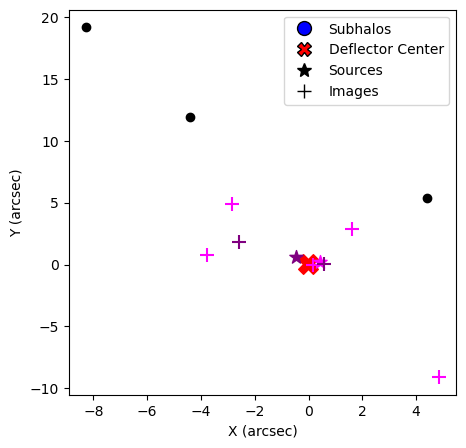

In [14]:
lens_model_object, model_params = lens.deflector_mass_model_lenstronomy()
image_positions = lens.extended_source_image_positions
point_source_image_positions = lens.point_source_image_positions()
print(
    f"Number of lens models: {len(model_params)} lens models: {np.unique(lens_model_object.lens_model_list, return_counts=True, return_index=True, axis=0)}"
)

mask = []
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for model in model_params[2:]:
    try:
        x_pos, y_pos = (model["center_x"], model["center_y"])
    except KeyError:
        continue

    if (np.abs(x_pos) < 50) and (np.abs(y_pos) < 50):

        ax.scatter(x_pos, y_pos, color="black", label="Subhalos")

        mask.append(1)
    else:
        mask.append(0)

x_pos, y_pos = (deflector_center[0], deflector_center[1])

ax.scatter(x_pos, y_pos, color="red", marker="X", label="Deflector Center", s=200)
print(x_pos, y_pos)
color_list = ["magenta", "purple", "blue"]
for s, image, color in zip(valid_sources, image_positions, color_list):
    x_pos, y_pos = (s.extended_source_position[0], s.extended_source_position[1])
    if (np.abs(x_pos) < 50) and (np.abs(y_pos) < 50):
        ax.scatter(x_pos, y_pos, marker="*", color=color, label="Sources", s=100)
        for ra, dec in zip(image[0], image[1]):
            x_pos, y_pos = (ra, dec)

            ax.scatter(x_pos, y_pos, marker="+", s=100, color=color, label="Images")

plt.legend(
    labels=["Subhalos", "Deflector Center", "Sources", "Images"],
    handles=[
        plt.Line2D(
            [0], [0], marker="o", color="none", markerfacecolor="blue", markersize=10
        ),
        plt.Line2D(
            [0], [0], marker="X", color="none", markerfacecolor="red", markersize=10
        ),
        plt.Line2D(
            [0], [0], marker="*", color="none", markerfacecolor="black", markersize=10
        ),
        plt.Line2D(
            [0], [0], marker="+", color="none", markerfacecolor="black", markersize=10
        ),
    ],
)
plt.xlabel("X (arcsec)")
plt.ylabel("Y (arcsec)")
plt.show()

Checking if all deflectors are within the cutout:

In [15]:
print(mask)

[1, 1, 1]


#### Simulate RGB image of the lensing system.

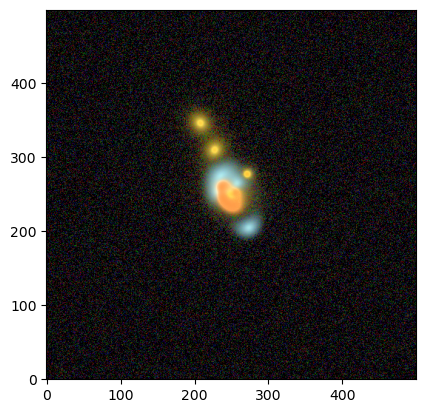

In [16]:
cluster_lens_plot = LensingPlots(lenspop, num_pix=500, coadd_years=5)

image_rgb = cluster_lens_plot.rgb_image(lens_class=lens, rgb_band_list=["i", "r", "g"])
plt.imshow(image_rgb, origin="lower")
plt.show()

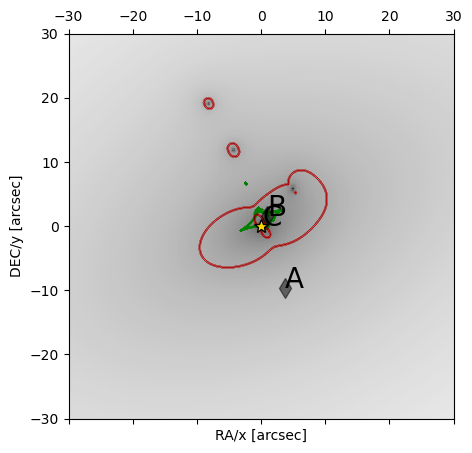

In [17]:
lens_cosmo = lens_model_object.cosmo
lens_model_analytical = lens_model_object
kwargs_lens_analytical = model_params


f, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(
    ax,
    lensModel=lens_model_object,
    kwargs_lens=model_params,
    numPix=300,
    deltaPix=0.2,
    with_convergence=True,
    with_shear=True,
    point_source=True,
    with_caustics=True,
    fast_caustic=False,
    coord_inverse=False,
)
plt.show()

## Cluster lens injection into DP0.2 cutouts
#### Here, we read the .fits files retrieved from RSP back into science pipeline objects to proceed with the injection.

In [18]:
coadd_dir = "/data/a.saricaoglu/webdav/coadd_fits"
tract, patch = 4639, 47
rgb_band_list = rgb_band_list = ["i", "r", "g"]
coadd, coadd_nImage, mag_zero_visit, variance_map, psf_stack = [], [], [], [], []
extra = fits.open(f"{coadd_dir}/deepCoadd_extra_tract{tract}_patch{patch}.fits")[1].data

for band in rgb_band_list:

    coadd_cut = ExposureF(
        f"{coadd_dir}/deepCoadd_{band}_tract{tract}_patch{patch}.fits"
    )
    coadd.append(coadd_cut)

    coadd_nImage_cut = ImageU(
        f"{coadd_dir}/nImage_{band}_tract{tract}_patch{patch}.fits"
    )
    coadd_nImage.append(coadd_nImage_cut)

    coadd_mag_zero = extra[f"band_{band}_mag_zero_point"][0]
    mag_zero_visit.append(coadd_mag_zero)

    coadd_var = ImageF(f"{coadd_dir}/variance_{band}_tract{tract}_patch{patch}.fits")
    variance_map.append(coadd_var)

In [19]:
def get_transformation_matrix(coadd):
    """
    Get the transformation matrix from pixel to angle for a list of coadd exposures.

    Parameters:
    -----------
    coadd : list of afwImage.ExposureF
        List of coadd exposures for different bands.

    Returns:
    --------
    lsst.geom.LinearTransform
        Transformation matrix from pixel to angle.
    """
    if not coadd:
        raise ValueError("The coadd list is empty.")

    wcs = coadd[0].getWcs()

    # Get CD (coordinate transformation) matrix
    cd = wcs.getCdMatrix()  # in degrees per pixel

    # Convert to arcseconds per pixel
    deg_to_arcsec = 3600.0
    pixel_scale_x = np.sqrt(cd[0, 0] ** 2 + cd[1, 0] ** 2) * deg_to_arcsec
    pixel_scale_y = np.sqrt(cd[0, 1] ** 2 + cd[1, 1] ** 2) * deg_to_arcsec

    # Construct the simplified pixel scale matrix
    transform_pix2sky = np.array([[pixel_scale_x, 0], [0, pixel_scale_y]])

    return transform_pix2sky

In [20]:
# Perform lens injection
uinjected_images = [
    coadd[rgb_band_list.index("i")].image.array,
    coadd[rgb_band_list.index("r")].image.array,
    coadd[rgb_band_list.index("g")].image.array,
]
final_uninjected_image = rgb_image_from_image_list(
    image_list=uinjected_images, stretch=2
)

matrix = get_transformation_matrix(coadd)
lens_list = [lens]
lens_number_per_cluster = 1

injection_table = lsst_science_pipeline.lens_injection_fast_coadd(
    lens_pop=lens_list,
    num_pix=500,
    transform_pix2angle=matrix,
    coadd=coadd,
    coadd_nImage=coadd_nImage,
    mag_zero_visit=mag_zero_visit,
    variance_map=variance_map,
    band_list=rgb_band_list,
    lens_cut=kwargs_lens_cut,
    num_cutout_per_patch=lens_number_per_cluster,
)

/grad/a.saricaoglu/home_repos/slsim_lsstsw/lsst_stack/lsstsw/miniconda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/astropy/visualization/lupton_rgb.py:645: RuntimeWarning: invalid value encountered in divide
  fInorm = np.where(Int <= 0, 0, np.true_divide(fI, Int))
/grad/a.saricaoglu/home_repos/slsim_lsstsw/lsst_stack/lsstsw/miniconda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/lenstronomy/LensModel/MultiPlane/multi_plane.py:77: UserWarning: Cosmology is provided. Make sure your cosmological model is consistent with the cosmology_model argument.
  warnings.warn(
/grad/a.saricaoglu/home_repos/slsim_lsstsw/lsst_stack/lsstsw/miniconda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/grad/a.saricaoglu/home_repos/slsim_lsstsw/lsst_stack/lsstsw/miniconda/envs/lsst-scipipe-12.0.0/lib/python3.13/

Processing lens_id: CLUSTER-GAL-LENS_-0.0304_0.0032 at box center: [ 55.6995828  -29.78042238] with bbox: (minimum=(23182, 26603), maximum=(23681, 27102))


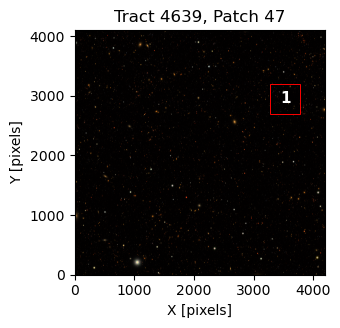

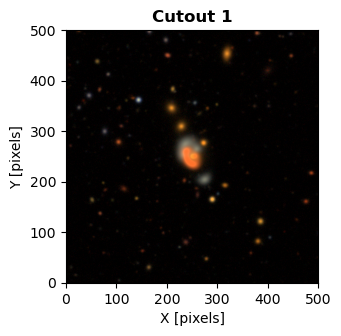

In [21]:
lens_ = injection_table[0]

lens_cluster_class = lens_["lens_class"]

lens_id = lens_cluster_class.generate_id()

lens_image = lens_["lens"]

cutout_image = lens_["cutout_image"]

injected_image_list = [
    lens_["injected_lens_i"],
    lens_["injected_lens_r"],
    lens_["injected_lens_g"],
]

box_center = lens_["cutout_center"]

cutout_bbox = lens_["cutout_bbox"]

print(
    f"Processing lens_id: {lens_id} at box center: {box_center} with bbox: {cutout_bbox}"
)
n = 0
# Create FITS file with multiple extensions
# Get WCS and coordinate information

center = SkyCoord(
    ra=box_center[0] * u.degree, dec=box_center[1] * u.degree, frame="icrs"
)


# Find closest SLED target
# idx = skycoord_sled.separation(center).argmin()

final_injected_image = rgb_image_from_image_list(
    image_list=injected_image_list, stretch=2
)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
coadd_cut_r = coadd[rgb_band_list.index("r")]
wcs = coadd_cut_r.getWcs()
bbox = coadd_cut_r.getBBox()
ax.imshow(
    final_uninjected_image, origin="lower", extent=[0, bbox.width, 0, bbox.height]
)
ax.set_title(f"Tract {tract}, Patch {patch}")
# Add rectangle to main plot - convert coordinates properly
cutout_rect = Rectangle(
    (
        cutout_bbox.beginX - bbox.beginX,
        cutout_bbox.beginY - bbox.beginY,
    ),  # Relative to main image
    cutout_bbox.width,
    cutout_bbox.height,
    linewidth=0.7,
    edgecolor="red",
    facecolor="none",
)
ax.add_patch(cutout_rect)
# Add cutout number as text annotation near the rectangle
cutout_center_x = (cutout_bbox.beginX - bbox.beginX) + cutout_bbox.width / 2
cutout_center_y = (cutout_bbox.beginY - bbox.beginY) + cutout_bbox.height / 2

# Method 1: Number in center of rectangle with background
ax.text(
    cutout_center_x,
    cutout_center_y,
    str(n + 1),
    fontsize=11,
    fontweight="bold",
    color="white",
    ha="center",
    va="center",
)
ax.set_xlabel("X [pixels]")
ax.set_ylabel("Y [pixels]")
ax.set_title(f"Tract {tract}, Patch {patch}")
# ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()
plt.close(fig)

fig_, ax_ = plt.subplots(figsize=(3.5, 3.5))
ax_.imshow(
    final_injected_image,
    origin="lower",
    extent=[0, cutout_bbox.width, 0, cutout_bbox.height],
)
ax_.set_title(f"Cutout {n+1}", fontsize=12, fontweight="bold")
ax_.set_ylabel("Y [pixels]")
ax_.set_xlabel("X [pixels]")
fig_.tight_layout()
plt.show()
plt.close(fig_)

## Modelling of the injected lens


In [22]:
SIGMA_TO_FWHM = 2.0 * np.sqrt(2.0 * np.log(2.0))


def getPsfProperties(psf, point):
    """Function to obtain PSF properties.

    Parameters
    ----------
    psf : `lsst.meas.extensions.psfex.PsfexPsf`
        PSF object.
    point : `lsst.geom.Point2D`
        Coordinate where the PSF is being evaluated.

    Returns
    -------
    fwhm : `float`
        Full-width at half maximum: PSF determinant radius
        from SDSS adaptive moments matrix (sigma) times
        SIGMA_TO_FWHM.
    ap_flux : `float`
        PSF flux from aperture photometry weighted
        by a sinc function.
    peak : `float`
        Peak PSF value.
    dims : `lsst.geom.ExtendI`
        PSF postage stamp dimensions.
    """
    sigma = psf.computeShape(point).getDeterminantRadius()
    fwhm = sigma * SIGMA_TO_FWHM
    ap_flux = psf.computeApertureFlux(radius=sigma, position=point)
    peak = psf.computePeak(position=point)
    dims = psf.computeImage(point).getDimensions()

    print(
        f"PSF FWHM: {fwhm:.4} pix \n"
        f"PSF flux from aperture photometry: {ap_flux:.4} \n"
        f"Peak PSF value: {peak:.4} \n"
        f"PSF postage stamp dimensions: {dims} \n"
    )

    return fwhm, dims[0]

#### Here, we prepare kwargs_data, kwargs_psf and kwargs_numerics of the injected image for multi-band modelling.

In [32]:
kwargs_data = {}
kwargs_psf = {}
kwargs_numerics = {}
multi_band_list = []
for band in rgb_band_list:

    hdul = fits.open(f"{coadd_dir}/deepCoadd_{band}_tract{tract}_patch{patch}.fits")
    exp = ExposureF(f"{coadd_dir}/deepCoadd_{band}_tract{tract}_patch{patch}.fits")

    band = hdul[5].data["band"][0]
    kwargs_psf = {}
    kwargs_data = {}
    kwargs_numerics = {}

    header = hdul["IMAGE"].header
    deltapix = abs(header["CD1_1"]) * 3600  # arcsec/pix
    info_coadd = exp.getInfo()
    info_visit = info_coadd.getVisitInfo()
    psf_coadd = info_coadd.getPsf()
    sphere_point = SpherePoint(center.ra.degree * degrees, center.dec.degree * degrees)
    wcs_coadd = info_coadd.getWcs()
    point_image = wcs_coadd.skyToPixel(sphere_point)
    fwhm_pix, dims = getPsfProperties(psf_coadd, point_image)
    fwhm = deltapix * fwhm_pix
    psf_type = "PIXEL"
    supersampling_factor = 1

    exposure_time = hdul[16].data["exposureTime"][0]
    (
        x_grid,
        y_grid,
        ra_at_xy_0,
        dec_at_xy_0,
        x_at_radec_0,
        y_at_radec_0,
        Mpix2coord,
        Mcoord2pix,
    ) = util.make_grid_with_coordtransform(numPix=500, deltapix=0.2, inverse=False)

    mag_zero_visit = 2.5 * np.log10(exp.getPhotoCalib().getInstFluxAtZeroMagnitude())
    if band == "r":
        mag_zero_r = mag_zero_visit
    var = hdul["VARIANCE"].data
    background_rms = np.sqrt(np.median(var))
    var_img = ImageF(f"{coadd_dir}/variance_{band}_tract4639_patch47.fits")
    var_cut = var_img[cutout_bbox]  # still an ImageF
    var_arr = var_cut.getArray()  # <-- NumPy array view, shape (y,x)
    noise_map = np.sqrt(np.clip(var_arr, 0, None))
    noise_map = np.maximum(noise_map, 1e-6 * np.median(noise_map))
    kwargs_data["image_data"] = lens_[f"injected_lens_{band}"]
    # kwargs_data["background_rms"] = background_rms
    kwargs_data["transform_pix2angle"] = matrix
    kwargs_data["ra_at_xy_0"] = ra_at_xy_0
    kwargs_data["dec_at_xy_0"] = dec_at_xy_0
    kwargs_data["exposure_time"] = exposure_time
    kwargs_data["noise_map"] = noise_map

    # kwargs_data['magnitude_zero_point'] = mag_zero_visit
    kernel = fits.getdata(f"{coadd_dir}/psf_{band}_tract4639_patch47.fits")
    kwargs_psf["pixel_size"] = deltapix
    kwargs_psf["fwhm"] = fwhm
    kwargs_psf["psf_type"] = psf_type
    kwargs_psf["kernel_point_source"] = kernel
    kwargs_psf["truncation"] = 4 * fwhm

    kwargs_numerics = {
        "supersampling_factor": supersampling_factor,
        "supersampling_convolution": True,
    }

    multi_band_list.append([kwargs_data, kwargs_psf, kwargs_numerics])
    print(band)

PSF FWHM: 4.138 pix 
PSF flux from aperture photometry: 0.3577 
Peak PSF value: 0.04865 
PSF postage stamp dimensions: (59, 59) 

i
PSF FWHM: 4.18 pix 
PSF flux from aperture photometry: 0.3562 
Peak PSF value: 0.04769 
PSF postage stamp dimensions: (59, 59) 

r
PSF FWHM: 4.624 pix 
PSF flux from aperture photometry: 0.3556 
Peak PSF value: 0.03948 
PSF postage stamp dimensions: (57, 57) 

g


#### Preparing models and parameters for fitting.

In [43]:
lens_mass_model_list, lens_model_params = (
    lens_cluster_class.deflector_mass_model_lenstronomy()
)
source_light_model_list, source_light_params = (
    lens_cluster_class.source_light_model_lenstronomy(band="r")
)
lens_light_model_list, lens_light_params = (
    lens_cluster_class.deflector_light_model_lenstronomy(band="r")
)
data_class = ImageData(**multi_band_list[1][0])
psf = PSF(**multi_band_list[1][1])

lightModel_source = LightModel(
    light_model_list=source_light_model_list["source_light_model_list"]
)
lightModel_lens = LightModel(light_model_list=lens_light_model_list)
new = []
for param in lens_light_params:
    param = {
        "amp": param_util.magnitude_to_amplitude(param["magnitude"], mag_zero_r),
        **param,
    }
    del param["magnitude"]
    new.append(param)
lens_light_params = new
lens_light_params_copy = deepcopy(lens_light_params)
lens_model_params_copy = deepcopy(lens_model_params)

image_linear_fit = ImageLinearFit(
    data_class=data_class,
    psf_class=psf,
    lens_model_class=lens_model_object,
    source_model_class=lightModel_source,
    lens_light_model_class=lightModel_lens,
    kwargs_numerics=kwargs_numerics,
)
new = []
for param in source_light_params["kwargs_source"]:
    # print(param['magnitude'])
    param = {
        "amp": param_util.magnitude_to_amplitude(param["magnitude"], mag_zero_r),
        **param,
    }
    del param["magnitude"]
    new.append(param)
source_light_params = new
source_light_params_copy = deepcopy(source_light_params)

image_reconstructed, _, _, _ = image_linear_fit.image_linear_solve(
    kwargs_lens=lens_model_params_copy,
    kwargs_source=source_light_params_copy,
    kwargs_lens_light=lens_light_params_copy,
    kwargs_ps=None,
)

-248.84085523183558 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  386.54266754322873
reduced chi^2 of data  1 =  309.29176821404167
reduced chi^2 of data  2 =  50.68812993823633


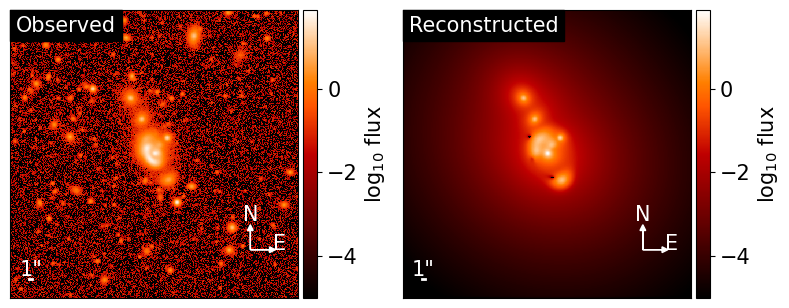

In [44]:
# illustrate fit #

kwargs_model = {
    "lens_model_list": lens_mass_model_list.lens_model_list,
    "source_light_model_list": source_light_model_list["source_light_model_list"],
    "lens_light_model_list": lens_light_model_list,
}  # , 'point_source_model_list': point_source_model_list}
kwargs_params = {
    "kwargs_lens": lens_model_params_copy,
    "kwargs_source": source_light_params_copy,
    "kwargs_lens_light": lens_light_params_copy,
}
lensPlot = ModelPlot(
    multi_band_list=multi_band_list,
    multi_band_type="multi-linear",
    kwargs_model=kwargs_model,
    kwargs_params=kwargs_params,
    arrow_size=0.02,
)

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
lensPlot.data_plot(ax=axes[0])
lensPlot.model_plot(ax=axes[1])

f.tight_layout()
plt.show()

#### Find the clumps in the injected image to verify that the coordinate/pixel transormations are correct.


250.01048010297262 249.8672593458788
271.4389831310792 276.4922593459313
227.48954358722602 309.19725934589576
208.20221019523075 345.4472593459054
251.68874258145084 250.58009104147322
247.08863264156645 252.64026030870622


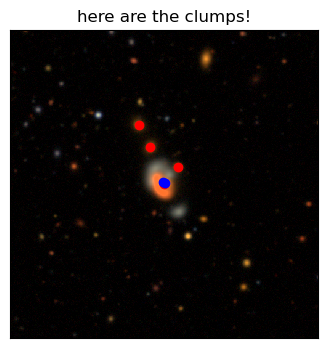

In [45]:
(
    x_grid,
    y_grid,
    ra_at_xy_0,
    dec_at_xy_0,
    x_at_radec_0,
    y_at_radec_0,
    Mpix2coord,
    Mcoord2pix,
) = util.make_grid_with_coordtransform(numPix=500, deltapix=0.2, inverse=False)

coordinates = Coordinates(
    ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0, transform_pix2angle=Mpix2coord
)

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(final_injected_image, origin="lower")
ax.set_title("here are the clumps!")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

for i in range(1, len(lens_model_object.lens_model_list[:-1])):
    kwargs = model_params[i]
    x_pos, y_pos = coordinates.map_coord2pix(kwargs["center_x"], kwargs["center_y"])
    print(x_pos, y_pos)

    ax.plot(x_pos, y_pos, "or")
for i in range(0, len(source_light_params)):
    kwargs = source_light_params[i]
    x_pos, y_pos = coordinates.map_coord2pix(kwargs["center_x"], kwargs["center_y"])
    print(x_pos, y_pos)
    ax.plot(x_pos, y_pos, "ob")

plt.show()

#### We decouple the multiplane for computationally more efficient ray tracing, as recommended in Lenstronomy tutorials.

In [46]:
# set up the grid for interpolation
grid_size = 500 * 0.2
# this is the grid resolution we use to ray-trace through the lens volume when setting up the interpolated deflection field. When
# super-sampling, you should increase this resolution accordingly
grid_resolution = deltapix / kwargs_numerics["supersampling_factor"]
x_grid, y_grid, interp_points, npix = setup_grids(grid_size, grid_resolution)

# here we break off the first two lens models (the macromodel) from the rest of the line of sight
index_lens_split = [0, len(lens_model_params) - 1]

(
    lens_model_fixed,
    lens_model_free,
    kwargs_lens_fixed,
    kwargs_lens_free,
    z_source,
    z_split,
    cosmo_bkg,
) = setup_lens_model(lens_model_object, lens_model_params, index_lens_split)

# do the interpolation of the deflection fields
xD, yD, alpha_x_foreground, alpha_y_foreground, alpha_beta_subx, alpha_beta_suby = (
    coordinates_and_deflections(
        lens_model_fixed,
        lens_model_free,
        kwargs_lens_fixed,
        kwargs_lens_free,
        x_grid,
        y_grid,
        z_split,
        z_source,
        cosmo_bkg,
    )
)

# set up the new lens model
kwargs_class_setup = decoupled_multiplane_class_setup(
    lens_model_free,
    xD,
    yD,
    alpha_x_foreground,
    alpha_y_foreground,
    alpha_beta_subx,
    alpha_beta_suby,
    z_split,
    coordinate_type="GRID",
    interp_points=interp_points,
)

lens_model_macro = lens_model_free
kwargs_lens_macro = kwargs_lens_free
lens_model_multiplane = lens_model_object
kwargs_lens = model_params

#### Comparison of full ray-tracing and decoupled ray-tracing
QUESTION #3- Unlike the example on the tutorials, in my case full ray-tracing takes less time than the decoupled? That was the case for all previous lenses simuated too. What could be the reason? Should I consider full-ray tracing for the model fitting?

time for full ray tracing:  1.0981402397155762
EXACT


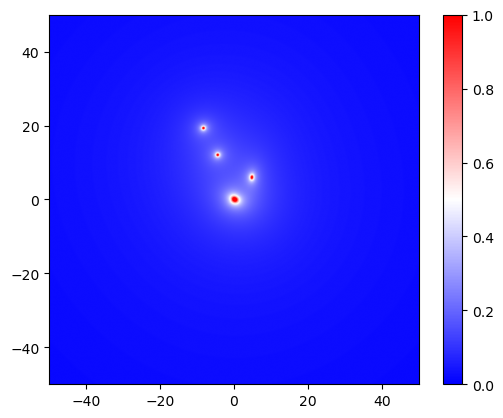

In [30]:
lens_model_decoupled = LensModel(**kwargs_class_setup)
kappa_macro = lens_model_macro.kappa(x_grid, y_grid, kwargs_lens_macro).reshape(
    npix, npix
)

t0 = time()
kappa_full_true = lens_model_multiplane.kappa(x_grid, y_grid, kwargs_lens).reshape(
    npix, npix
)
print("time for full ray tracing: ", time() - t0)
print("EXACT")
plt.figure()
extent = [-grid_size / 2, grid_size / 2, -grid_size / 2, grid_size / 2]
delta_kappa = kappa_full_true - kappa_macro
vminmax = 1
im = plt.imshow(
    delta_kappa, cmap="bwr", vmin=0, vmax=vminmax, origin="lower", extent=extent
)
plt.colorbar(im)
plt.show()

time for decoupled ray tracing:  12.572152137756348
DECOUPLED


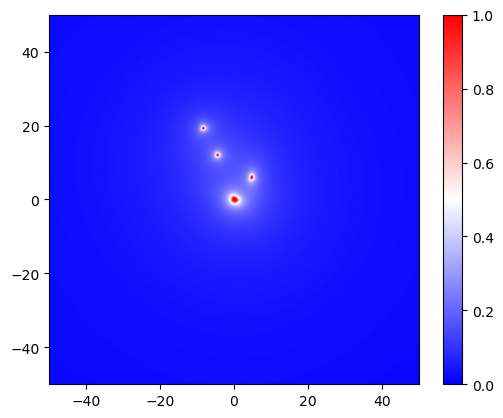

In [31]:
t0 = time()
kappa_full_decoupled = lens_model_decoupled.kappa(
    x_grid, y_grid, kwargs_lens_macro
).reshape(npix, npix)
print("time for decoupled ray tracing: ", time() - t0)
print("DECOUPLED")
plt.figure()
delta_kappa2 = kappa_full_decoupled - kappa_macro
im2 = plt.imshow(
    delta_kappa2, cmap="bwr", vmin=0, vmax=vminmax, origin="lower", extent=extent
)
plt.colorbar(im2)
plt.show()

In [ ]:
kwargs_lens_macro = deepcopy(kwargs_lens_macro)
kwargs_lens_fixed = deepcopy(kwargs_lens_fixed)

print(lens_light_params)

In [47]:
print(lens_model_macro.lens_model_list)

['NFW_ELLIPSE_CSE', 'SHEAR']


## Simple Fitting
#### Fitting schema below only involves the extended sources.

In [48]:
source_model_list = source_light_model_list["source_light_model_list"]
# joint_source_with_point_source = [[0,0]]*3
lens_light_model_list = lens_light_model_list
# point_source_list = ['LENSED_POSITION']

kwargs_model = {
    "lens_model_list": lens_model_macro.lens_model_list,
    "lens_redshift_list": [lens_cluster_class.deflector_redshift[0]] * 2,
    "source_redshift_list": lens_cluster_class.source_redshift_list,
    "kwargs_lens_eqn_solver": {"arrival_time_sort": False},
    "z_source": np.max(lens_cluster_class.source_redshift_list),
    # to specify this option in the lens modeling, all we have to do is specify
    # decouple_multi_plane=True, kwargs_multiplane_model=kwargs_class_setup['kwargs_multiplane_model'],
    # and multi_plane=True. See the cell #4 for how to set up kwargs_class_setup['kwargs_multiplane_model']
    "multi_plane": True,
    "decouple_multi_plane": True,
    "kwargs_multiplane_model": kwargs_class_setup["kwargs_multiplane_model"],
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
    # 'point_source_model_list': ['LENSED_POSITION']*9,
    # 'additional_images_list': [False]*9,
    # 'fixed_magnification_list': [False]*9,  # list of bools (same length as point_source_type_list). If True, magnification ratio of point sources is fixed to the one given by the lens model
}

num_source_model = len(source_model_list)
kwargs_constraints = {}
prior_lens = None
prior_lens_light = None
kwargs_likelihood = {
    "check_bounds": True,
    "source_marg": False,
}

#'image_likelihood_mask_list': [likelihood_mask],
# image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
# multi_band_list = [image_band]
kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "multi-linear",
}
n_max_epl = 1
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
shapelets_init = {
    "amp": 1.0,
    "beta": 1e-1,
    "n_max": n_max_epl,
    "center_x": 0.0,
    "center_y": 0.0,
}
shapelets_sigma = {
    "amp": 10.0,
    "beta": 0.2,
    "n_max": 1.0,
    "center_x": 0.1,
    "center_y": 0.1,
}
shapelets_min = {
    "amp": 0.00001,
    "beta": 1e-10,
    "n_max": 1.0,
    "center_x": -1.0,
    "center_y": -1.0,
}
shapelets_max = {
    "amp": 1000.0,
    "beta": 100.0,
    "n_max": 10.0,
    "center_x": 1.0,
    "center_y": 1.0,
}

kwargs_lens_init = kwargs_lens_macro
# kwargs_source_init = source_light_params + [shapelets_init]
kwargs_source_init = [
    {
        "amp": 100.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "e1": 0.01,
        "e2": 0.04,
        "R_sersic": 0.1,
        "n_sersic": 4.0,
    }
] * len(source_light_params) + [shapelets_init]
# kwargs_lens_light_init = lens_light_params
kwargs_lens_light_init = [
    {
        "amp": 100.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "e1": 0.01,
        "e2": 0.04,
        "R_sersic": 0.1,
        "n_sersic": 4.0,
    }
] * len(lens_light_params)
# kwargs_ps_init = [[{'ra_image' : kw[0]['ra_image'],'dec_image': kw[0]['dec_image']}] for kw in kwargs_ps]

kwargs_lens_sigma = [
    {"alpha_Rs": 0.1, "Rs": 0.5, "e1": 0.4, "e2": 0.4, "center_x": 1, "center_y": 1},
    {"gamma1": 0.02, "gamma2": 0.02},
]
kwargs_source_sigma = [
    {
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "e1": 0.4,
        "e2": 0.4,
        "center_x": 1,
        "center_y": 1,
    }
] * len(source_light_params) + [shapelets_sigma]
kwargs_lens_light_sigma = [
    {
        "R_sersic": 0.1,
        "n_sersic": 0.2,
        "e1": 0.4,
        "e2": 0.4,
        "center_x": 1,
        "center_y": 1,
    }
] * len(lens_light_params)
kwargs_ps_sigma = []

# hard bound lower limit in parameter space #
kwargs_lower_lens = [
    {
        "Rs": 0.8,
        "alpha_Rs": 0,
        "center_x": -50,
        "center_y": -50,
        "e1": -0.5,
        "e2": -0.5,
    },
    {"gamma1": -0.5, "gamma2": -0.5},
]
kwargs_lower_source = [
    {
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -50,
        "center_y": -50,
    }
] * len(source_light_params) + [shapelets_min]
kwargs_lower_lens_light = [
    {
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -50,
        "center_y": -50,
    }
] * len(lens_light_params)
kwargs_lower_ps = []

# hard bound upper limit in parameter space #
kwargs_upper_lens = [
    {"Rs": 1000, "alpha_Rs": 100, "center_x": 50, "center_y": 50, "e1": 0.5, "e2": 0.5},
    {"gamma1": 0.5, "gamma2": 0.5},
]
kwargs_upper_source = [
    {
        "R_sersic": 10.0,
        "n_sersic": 10.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 50,
        "center_y": 50,
    }
] * len(source_light_params) + [shapelets_max]
kwargs_upper_lens_light = [
    {
        "R_sersic": 10,
        "n_sersic": 10.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 50,
        "center_y": 50,
    }
] * len(lens_light_params)
kwargs_upper_ps = []

# keeping parameters fixed
kwargs_lens_fixed = [{}, {"ra_0": 0.0, "dec_0": 0.0}]
kwargs_source_fixed = [{}, {}, {"n_max": 1, "amp": 0.0}]
kwargs_lens_light_fixed = [{}] * len(lens_light_params)
# kwargs_ps_fixed = [{}]*9

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    kwargs_lens_fixed,
    kwargs_lower_lens,
    kwargs_upper_lens,
]
source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    kwargs_source_fixed,
    kwargs_lower_source,
    kwargs_upper_source,
]
lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    kwargs_lens_light_fixed,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]
# ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
    "point_source_model": None,
}

fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

nthreads = 32
fitting_kwargs_list = [
    [
        "PSO",
        {
            "sigma_scale": 1.0,
            "n_particles": 30,
            "n_iterations": 100,
            "threadCount": nthreads,
        },
    ]
]

In [49]:
# Fit the smooth lens system to the observations (which include substructure)
t0 = time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
tend = time()
print("time ellapsed (min): ", (tend - t0) / 60)
kwargs_result = fitting_seq.best_fit()

total_number_ray_tracing_calculations = (
    fitting_kwargs_list[0][1]["n_iterations"] * fitting_kwargs_list[0][1]["n_particles"]
)
time_per_PSO_iteration_with_approx = (tend - t0) / total_number_ray_tracing_calculations
print("TIME PER PSO ITERATION (sec): ", time_per_PSO_iteration_with_approx)

/grad/a.saricaoglu/home_repos/slsim_lsstsw/lsst_stack/lsstsw/miniconda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/multiprocess/popen_fork.py:67: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Computing the PSO ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:05<00:00,  9.05s/it]/grad/a.saricaoglu/home_repos/slsim_lsstsw/lsst_stack/lsstsw/miniconda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/multiprocess/popen_fork.py:67: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Max iteration reached! Stopping.
-54.741286701929795 reduced X^2 of best position
-20526285.533335913 log likelihood
749938 effective number of data points
[{'Rs': np.float64(139.48693528750064), 'alpha_Rs': np.float64(19.28368570133453), 'e1': np.float64(0.08277081534199614), 'e2': np.float64(0.11972653927851734), 'center_x': np.float64(0.09546091826813818), 'center_y': np.float64(0.1581054222576976)}, {'gamma1': np.float64(0.011291529062543059), 'gamma2': np.float64(0.02469150796996933), 'ra_0': 0.0, 'dec_0': 0.0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.36652892114274366), 'n_sersic': np.float64(1.4273728907118768), 'e1': np.float64(0.06825583490536513), 'e2': np.float64(-0.17405425576671682), 'center_x': np.float64(-0.30434178183561894), 'center_y': np.float64(0.06181830997501447)}, {'amp': 1, 'R_sersic': np.float64(1.4994585181306923), 'n_sersic': np.float64(3.404580768764928), 'e1': np.float64(-0.046957127302443745), 'e2': np.float64(-0.04060965983970368), 'center_x': np

QUESTION #4- Is there any method to improve this other than increasing particles and iterations? How do I know the upper and lower bounds I set above are optimal and I am not over/under-fitting?

dict_keys(['lens_model_list', 'lens_redshift_list', 'source_redshift_list', 'kwargs_lens_eqn_solver', 'z_source', 'multi_plane', 'decouple_multi_plane', 'kwargs_multiplane_model', 'source_light_model_list', 'lens_light_model_list'])
-54.7367614222291 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  52.31923380924975
reduced chi^2 of data  1 =  82.61825249739051
reduced chi^2 of data  2 =  29.272797960047022
(44, ['Rs_lens0', 'alpha_Rs_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_source_light1', 'n_sersic_source_light1', 'e1_source_light1', 'e2_source_light1', 'center_x_source_light1', 'center_y_source_light1', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_lig

/grad/a.saricaoglu/home_repos/slsim_lsstsw/lsst_stack/lsstsw/miniconda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1121: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


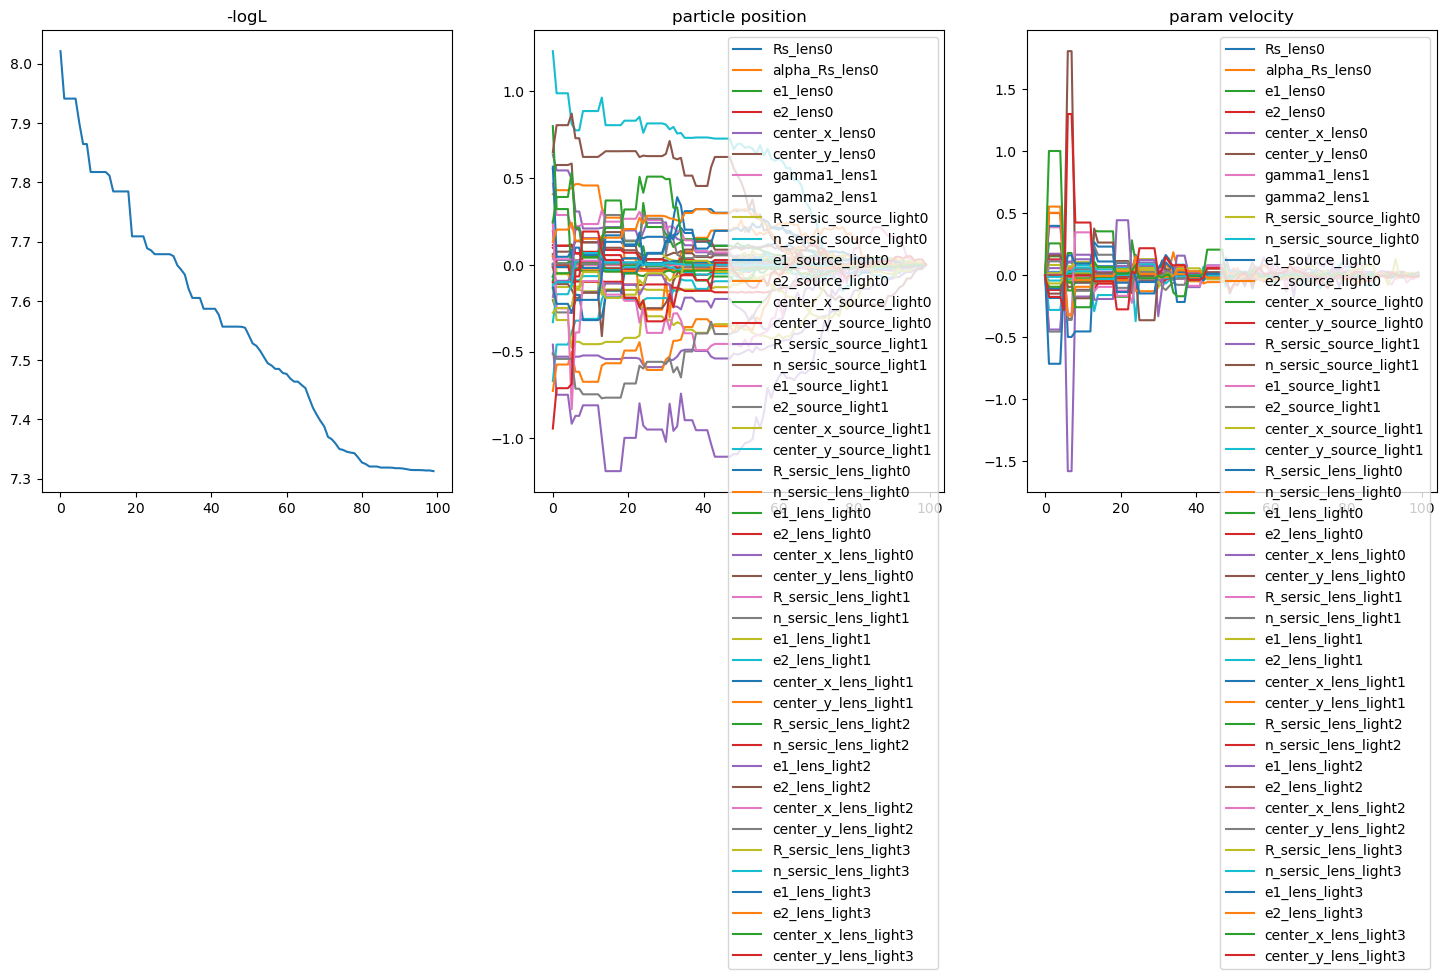

<Figure size 640x480 with 0 Axes>

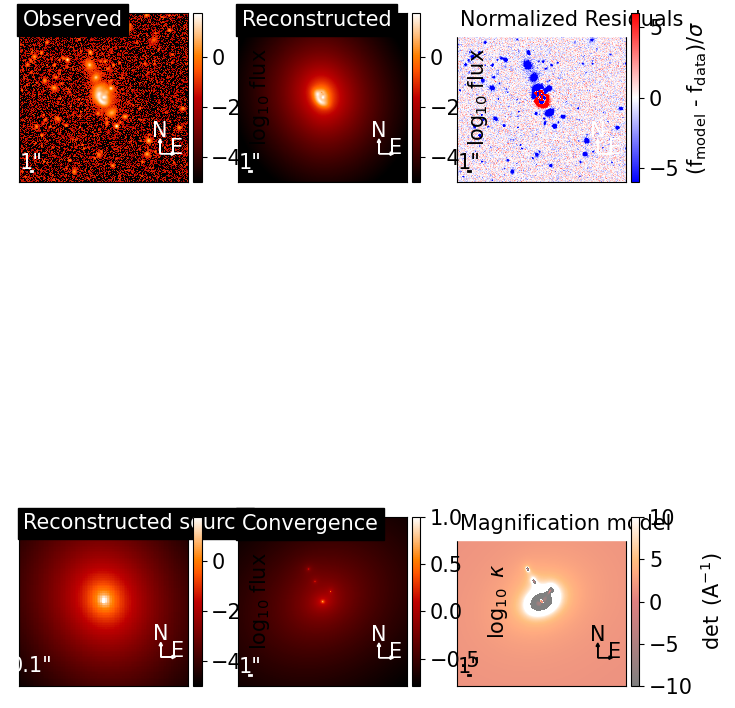

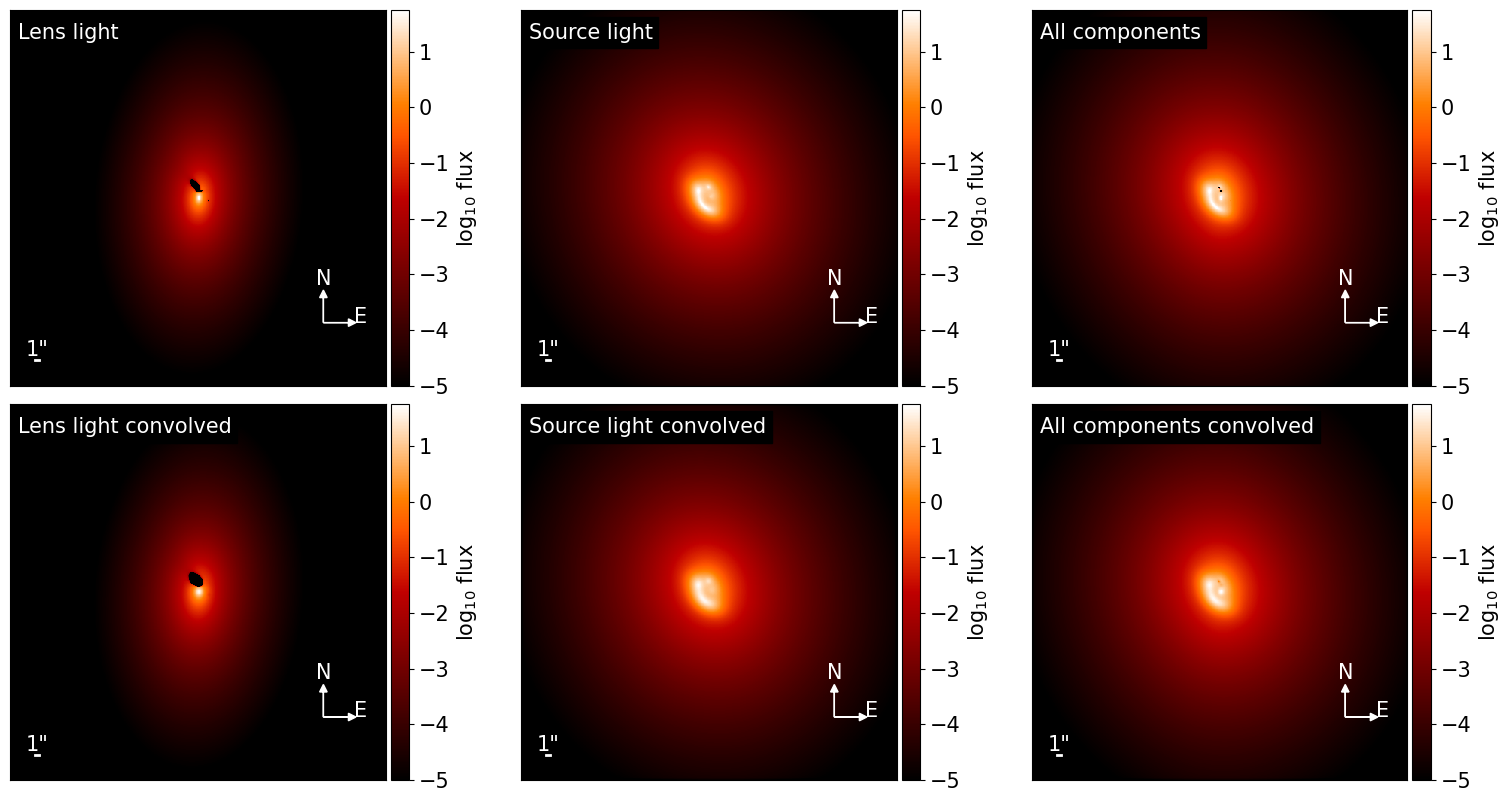

In [50]:
print(kwargs_model.keys())
modelPlot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="gist_heat",
    fast_caustic=True,
)

param_class = fitting_seq.param_class
print(param_class.num_param())
# print(chain_list)

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(2, 3, figsize=(8, 12), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0, 0])
modelPlot.model_plot(ax=axes[0, 1])
modelPlot.normalized_residual_plot(ax=axes[0, 2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=1, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
# f.tight_layout()
# f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
# plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
modelPlot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
modelPlot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
modelPlot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
modelPlot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
modelPlot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

In [ ]:
# and now we run the MCMC
fitting_kwargs_list = [
    ["MCMC", {"n_burn": 100, "n_run": 300, "walkerRatio": 6, "sigma_scale": 0.5}]
]
chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

## Fitting with point sources
#### Now we consider the image positions as lensed point sources.


Quickly recovering parameter arrays since since htey are modified by the fitting sequence previously.


In [ ]:
# update the data with the noisy image and its noise properties #
lens_mass_model_list, lens_model_params = (
    lens_cluster_class.deflector_mass_model_lenstronomy()
)
source_light_model_list, source_light_params = (
    lens_cluster_class.source_light_model_lenstronomy(band="r")
)
lens_light_model_list, lens_light_params = (
    lens_cluster_class.deflector_light_model_lenstronomy(band="r")
)
data_class = ImageData(**multi_band_list[1][0])
psf = PSF(**multi_band_list[1][1])

lightModel_source = LightModel(
    light_model_list=source_light_model_list["source_light_model_list"]
)
lightModel_lens = LightModel(light_model_list=lens_light_model_list)
new = []
for param in lens_light_params:
    param = {
        "amp": param_util.magnitude_to_amplitude(param["magnitude"], mag_zero_r),
        **param,
    }
    del param["magnitude"]
    new.append(param)
lens_light_params = new
lens_light_params_copy = deepcopy(lens_light_params)
lens_model_params_copy = deepcopy(lens_model_params)

image_linear_fit = ImageLinearFit(
    data_class=data_class,
    psf_class=psf,
    lens_model_class=lens_model_object,
    source_model_class=lightModel_source,
    lens_light_model_class=lightModel_lens,
    kwargs_numerics=kwargs_numerics,
)
new = []
for param in source_light_params["kwargs_source"]:
    # print(param['magnitude'])
    param = {
        "amp": param_util.magnitude_to_amplitude(param["magnitude"], mag_zero_r),
        **param,
    }
    del param["magnitude"]
    new.append(param)
source_light_params = new
source_light_params_copy = deepcopy(source_light_params)

image_reconstructed, _, _, _ = image_linear_fit.image_linear_solve(
    kwargs_lens=lens_model_params_copy,
    kwargs_source=source_light_params_copy,
    kwargs_lens_light=lens_light_params,
    kwargs_ps=None,
)

In [ ]:
# set up the grid for interpolation
grid_size = 500 * 0.2
# this is the grid resolution we use to ray-trace through the lens volume when setting up the interpolated deflection field. When
# super-sampling, you should increase this resolution accordingly
grid_resolution = deltapix / kwargs_numerics["supersampling_factor"]
x_grid, y_grid, interp_points, npix = setup_grids(grid_size, grid_resolution)

# here we break off the first two lens models (the macromodel) from the rest of the line of sight
index_lens_split = [0, 1]

(
    lens_model_fixed,
    lens_model_free,
    kwargs_lens_fixed,
    kwargs_lens_free,
    z_source,
    z_split,
    cosmo_bkg,
) = setup_lens_model(lens_model_object, lens_model_params, index_lens_split)

# do the interpolation of the deflection fields
xD, yD, alpha_x_foreground, alpha_y_foreground, alpha_beta_subx, alpha_beta_suby = (
    coordinates_and_deflections(
        lens_model_fixed,
        lens_model_free,
        kwargs_lens_fixed,
        kwargs_lens_free,
        x_grid,
        y_grid,
        z_split,
        z_source,
        cosmo_bkg,
    )
)

# set up the new lens model
kwargs_class_setup = decoupled_multiplane_class_setup(
    lens_model_free,
    xD,
    yD,
    alpha_x_foreground,
    alpha_y_foreground,
    alpha_beta_subx,
    alpha_beta_suby,
    z_split,
    coordinate_type="GRID",
    interp_points=interp_points,
)

lens_model_macro = lens_model_free
kwargs_lens_macro = kwargs_lens_free
lens_model_multiplane = lens_model_object
kwargs_lens = model_params

#### Constructing the point source arguments

In [ ]:
print(len(point_source_image_positions))
kwargs_ps = []
point_source_list = []
for source in point_source_image_positions:
    x_pos, y_pos = source[0], source[1]
    magnifications = np.absolute(
        lens_model_object.magnification(x_pos, y_pos, model_params)
    )
    kwargs_ps.append(
        {"ra_image": x_pos, "dec_image": y_pos, "point_amp": magnifications}
    )
    point_source_list.append("LENSED_POSITION")
print(kwargs_ps)
print(point_source_list)

In [33]:
source_model_list = source_light_model_list["source_light_model_list"]
joint_source_with_point_source = [[0, 0]] * len(point_source_list)
lens_light_model_list = lens_light_model_list
point_source_list = point_source_list

kwargs_model = {
    "lens_model_list": lens_model_macro.lens_model_list,
    "lens_redshift_list": [lens_cluster_class.deflector_redshift[0]] * 2,
    "source_redshift_list": lens_cluster_class.source_redshift_list,
    "kwargs_lens_eqn_solver": {"arrival_time_sort": False},
    "z_source": np.max(lens_cluster_class.source_redshift_list),
    # to specify this option in the lens modeling, all we have to do is specify
    # decouple_multi_plane=True, kwargs_multiplane_model=kwargs_class_setup['kwargs_multiplane_model'],
    # and multi_plane=True. See the cell #4 for how to set up kwargs_class_setup['kwargs_multiplane_model']
    "multi_plane": True,
    "decouple_multi_plane": True,
    "kwargs_multiplane_model": kwargs_class_setup["kwargs_multiplane_model"],
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
    "point_source_model_list": point_source_list,
    # 'additional_images_list': [False]*9,
    "fixed_magnification_list": [False]
    * len(
        point_source_list
    ),  # list of bools (same length as point_source_type_list). If True, magnification ratio of point sources is fixed to the one given by the lens model
}

num_source_model = len(source_model_list)
prior_lens = None

prior_lens_light = None
kwargs_likelihood = {
    "check_bounds": True,
    "force_no_add_image": True,
    "source_marg": False,
    "image_position_uncertainty": 0.004,
    "source_position_tolerance": 15,
    "source_position_sigma": 0.001,
    "prior_lens": prior_lens,
    "prior_lens_light": prior_lens_light,
}

#'image_likelihood_mask_list': [likelihood_mask],
# image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
# multi_band_list = [image_band]
kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "multi-linear",
}
n_max_epl = 1
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
shapelets_init = {
    "amp": 1.0,
    "beta": 1e-1,
    "n_max": n_max_epl,
    "center_x": 0.0,
    "center_y": 0.0,
}
shapelets_sigma = {
    "amp": 10.0,
    "beta": 0.2,
    "n_max": 1.0,
    "center_x": 0.1,
    "center_y": 0.1,
}
shapelets_min = {
    "amp": 0.00001,
    "beta": 1e-10,
    "n_max": 1.0,
    "center_x": -1.0,
    "center_y": -1.0,
}
shapelets_max = {
    "amp": 1000.0,
    "beta": 100.0,
    "n_max": 10.0,
    "center_x": 1.0,
    "center_y": 1.0,
}

kwargs_lens_init = kwargs_lens_macro
# kwargs_source_init = source_light_params + [shapelets_init]
kwargs_source_init = [
    {
        "amp": 100.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "e1": 0.01,
        "e2": 0.04,
        "R_sersic": 0.1,
        "n_sersic": 4.0,
    }
] * len(source_light_params) + [shapelets_init]
# kwargs_lens_light_init = lens_light_params
kwargs_lens_light_init = [
    {
        "amp": 100.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "e1": 0.01,
        "e2": 0.04,
        "R_sersic": 0.1,
        "n_sersic": 4.0,
    }
] * len(lens_light_params)
kwargs_ps_init = []

# initial spread in parameter estimation #
kwargs_lens_sigma = [
    {"alpha_Rs": 0.1, "Rs": 0.5, "e1": 0.4, "e2": 0.4, "center_x": 1, "center_y": 1},
    {"gamma1": 0.02, "gamma2": 0.02},
]
kwargs_source_sigma = [
    {
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "e1": 0.4,
        "e2": 0.4,
        "center_x": 1,
        "center_y": 1,
    }
] * 2 + [shapelets_sigma]
kwargs_lens_light_sigma = [
    {
        "R_sersic": 0.1,
        "n_sersic": 0.2,
        "e1": 0.4,
        "e2": 0.4,
        "center_x": 1,
        "center_y": 1,
    }
] * len(lens_light_params)
kwargs_ps_sigma = []

# hard bound lower limit in parameter space #
kwargs_lower_lens = [
    {"Rs": 0, "alpha_Rs": 0, "center_x": -50, "center_y": -50, "e1": -0.5, "e2": -0.5},
    {"gamma1": -0.5, "gamma2": -0.5},
]
kwargs_lower_source = [
    {
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -50,
        "center_y": -50,
    }
] * len(source_light_params) + [shapelets_min]
kwargs_lower_lens_light = [
    {
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -50,
        "center_y": -50,
    }
] * len(lens_light_params)
kwargs_lower_ps = []

# hard bound upper limit in parameter space #
kwargs_upper_lens = [
    {"Rs": 1000, "alpha_Rs": 100, "center_x": 50, "center_y": 50, "e1": 0.5, "e2": 0.5},
    {"gamma1": 0.5, "gamma2": 0.5},
]
kwargs_upper_source = [
    {
        "R_sersic": 10.0,
        "n_sersic": 10.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 50,
        "center_y": 50,
    }
] * len(source_light_params) + [shapelets_max]
kwargs_upper_lens_light = [
    {
        "R_sersic": 10,
        "n_sersic": 10.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 50,
        "center_y": 50,
    }
] * len(lens_light_params)
kwargs_upper_ps = []

# keeping parameters fixed
kwargs_lens_fixed = [{}, {"ra_0": 0.0, "dec_0": 0.0}]
kwargs_source_fixed = [{}, {}, {"n_max": 1, "amp": 0.0}]
kwargs_lens_light_fixed = [{}] * len(lens_light_params)
kwargs_ps_fixed = []

num_point_source_list = []
for i in range(len(point_source_list)):
    kwargs_ps_fixed.append(
        {"ra_image": kwargs_ps[i]["ra_image"], "dec_image": kwargs_ps[i]["dec_image"]}
    )  # we fix the image position coordinates
    kwargs_ps_init.append(
        {"ra_image": kwargs_ps[i]["ra_image"], "dec_image": kwargs_ps[i]["dec_image"]}
    )
    kwargs_ps_sigma.append(
        {
            "ra_image": 0.01 * np.ones(len(kwargs_ps[i]["ra_image"])),
            "dec_image": 0.01 * np.ones(len(kwargs_ps[i]["dec_image"])),
        }
    )
    kwargs_lower_ps.append(
        {
            "ra_image": -50 * np.ones(len(kwargs_ps[i]["ra_image"])),
            "dec_image": -50 * np.ones(len(kwargs_ps[i]["dec_image"])),
        }
    )
    kwargs_upper_ps.append(
        {
            "ra_image": 50 * np.ones(len(kwargs_ps[i]["ra_image"])),
            "dec_image": 50 * np.ones(len(kwargs_ps[i]["dec_image"])),
        }
    )
    num_point_source_list.append(len(kwargs_ps[i]["ra_image"]))

kwargs_constraints = {
    "joint_source_with_point_source": joint_source_with_point_source,
    "num_point_source_list": num_point_source_list,
}

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    kwargs_lens_fixed,
    kwargs_lower_lens,
    kwargs_upper_lens,
]
source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    kwargs_source_fixed,
    kwargs_lower_source,
    kwargs_upper_source,
]
lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    kwargs_lens_light_fixed,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]
ps_params = [
    kwargs_ps_init,
    kwargs_ps_sigma,
    kwargs_ps_fixed,
    kwargs_lower_ps,
    kwargs_upper_ps,
]

kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
    "point_source_model": ps_params,
}


fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

nthreads = 10
fitting_kwargs_list = [
    [
        "PSO",
        {
            "sigma_scale": 1.0,
            "n_particles": 30,
            "n_iterations": 100,
            "threadCount": nthreads,
        },
    ]
]

NameError: name 'point_source_list' is not defined

In [ ]:
# Fit the smooth lens system to the observations (which include substructure)
t0 = time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
tend = time()
print("time ellapsed (min): ", (tend - t0) / 60)
kwargs_result = fitting_seq.best_fit()

total_number_ray_tracing_calculations = (
    fitting_kwargs_list[0][1]["n_iterations"] * fitting_kwargs_list[0][1]["n_particles"]
)
time_per_PSO_iteration_with_approx = (tend - t0) / total_number_ray_tracing_calculations
print("TIME PER PSO ITERATION (sec): ", time_per_PSO_iteration_with_approx)

In [ ]:
print(kwargs_model.keys())
modelPlot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="gist_heat",
    fast_caustic=True,
)

param_class = fitting_seq.param_class
print(param_class.num_param())
# print(chain_list)

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(2, 3, figsize=(10, 12), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0, 0])
modelPlot.model_plot(ax=axes[0, 1])
modelPlot.normalized_residual_plot(ax=axes[0, 2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=1, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
# f.tight_layout()
# f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
# plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
modelPlot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
modelPlot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
modelPlot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
modelPlot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
modelPlot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

In [ ]:
fig = plt.figure()
fig.set_size_inches(6, 6)
ax = plt.subplot(111)
kwargs_plot = {
    "ax": ax,
    "index_macromodel": [0, 1],
    "with_critical_curves": True,
    "v_min": -0.2,
    "v_max": 0.2,
    "super_sample_factor": 3,
}
modelPlot.substructure_plot(band_index=1, **kwargs_plot)
print(kwargs_result)

## To be continued 

I will continue with MCMC sampling after I determine the best method (full or decoupled ray tracing, with or without known image positions)
